This notebook contains some experiments that investigate the use of Transformer models in predicting the on-target and off-target activity of Cas-13d gRNAs.

In [ ]:
import random, os, math, numpy as np, pandas as pd, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score
from scipy.stats import pearsonr, spearmanr

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.backends.cudnn.benchmark = True          # fixed-length speed-ups

df = pd.read_csv('/content/dataset.csv')
df = df[
    df['GuideSeq'].notnull() &
    df['TargetSeqContext'].notnull() &
    (df['GuideSeq'].str.len()  > 0) &
    (df['TargetSeqContext'].str.len() > 0)
].copy()
df = df[['GuideSeq', 'TargetSeqContext', 'log2FC']].dropna().drop_duplicates()
df.columns = ['guide', 'target', 'score']

train_val, test = train_test_split(df, test_size=0.10, random_state=SEED)
train, val      = train_test_split(train_val, test_size=0.1111, random_state=SEED)  # 10 % overall val

BASE2ID = {'A':0, 'C':1, 'G':2, 'T':3, 'N':4}   # unknown=N
PAD_ID  = len(BASE2ID)                          # 5
VOCAB   = PAD_ID + 1                            # 6
COMP    = str.maketrans('ACGTN', 'TGCAN')

def default_encode(seq: str):
    return torch.tensor([BASE2ID.get(b, 4) for b in seq], dtype=torch.long)

class DNAPair(Dataset):
    def __init__(self, frame): self.frame = frame.reset_index(drop=True)
    def __len__(self): return len(self.frame)
    def __getitem__(self, idx):
        r = self.frame.iloc[idx]
        return default_encode(r.guide), default_encode(r.target), torch.tensor(r.score, dtype=torch.float32)

def revcomp(seq: str) -> str:
    return seq.translate(COMP)[::-1]

def encode_pad(seq: str, pad_left: int = 0, pad_right: int = 0):
    ids = [BASE2ID.get(b, 4) for b in seq]
    return [PAD_ID]*pad_left + ids + [PAD_ID]*pad_right

# cheap local alignment (heuristic-based)
def best_offset(guide: str, target_rc: str) -> int:
    # slide guide along target (RC) and return the best 0-based offset for target_rc
    Lg, Lt, best, idx = len(guide), len(target_rc), -1, 0
    for off in range(Lt - Lg + 1):
        score = sum(guide[i] == target_rc[off+i] for i in range(Lg))
        if score > best:
            best, idx = score, off
    return idx          # 0-based offset into target_rc

def encode_seq(seq: str):
    return [ BASE2ID.get(b, 4) for b in seq ]

# aligned DNA pair dataset
class AlignedDNAPair(Dataset):
    def __init__(self, frame):
        self.data = frame.reset_index(drop=True)

    def __len__(self): return len(self.data)

    def __getitem__(self, idx):
        row       = self.data.iloc[idx]
        guide     = row['guide']
        target_rc = revcomp(row['target'])
        off       = best_offset(guide, target_rc)
        pad_left  = off
        pad_right = len(target_rc) - off - len(guide)
        g_ids = torch.tensor(encode_pad(guide, pad_left, pad_right), dtype=torch.long)
        t_ids = torch.tensor(encode_pad(target_rc, 0, 0),             dtype=torch.long)
        y     = torch.tensor(row['score'], dtype=torch.float32)
        return g_ids, t_ids, y

def collate(batch):
    g, t, y = zip(*batch)
    g = nn.utils.rnn.pad_sequence(g, batch_first=True, padding_value=PAD_ID)
    t = nn.utils.rnn.pad_sequence(t, batch_first=True, padding_value=PAD_ID)
    return g, t, torch.stack(y)

BATCH = 1024
TRAIN = DataLoader(AlignedDNAPair(train), batch_size=BATCH, shuffle=True ,collate_fn=collate, pin_memory=True, num_workers=4)
VAL   = DataLoader(AlignedDNAPair(val  ), batch_size=BATCH, shuffle=False, collate_fn=collate, pin_memory=True, num_workers=4)
TEST  = DataLoader(AlignedDNAPair(test ), batch_size=BATCH, shuffle=False, collate_fn=collate, pin_memory=True, num_workers=4)

class LearnedPE(nn.Module):
    def __init__(self, d_model:int, max_len:int=64):
        super().__init__()
        self.pe = nn.Parameter(torch.randn(max_len, d_model) * 0.02)
    def forward(self, x):                       # x: (B, L, d)
        return x + self.pe[:x.size(1)]

class ConvTransformer(nn.Module):
    def __init__(self, d_model: int = 128, num_heads: int = 4, num_layers: int = 4, vocab_size: int = VOCAB):
        super().__init__()
        self.embedding   = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = LearnedPE(d_model)
        # 2) build interleaved conv + attention blocks with residuals
        self.blocks = nn.ModuleList()
        for _ in range(num_layers):
            # a) Conv block
            conv_block = nn.Sequential(
                nn.Conv1d(d_model, d_model, kernel_size=5, padding=2),
                nn.GELU(),
                nn.Conv1d(d_model, d_model, kernel_size=3, padding=1),
                nn.GELU()
            )
            # b) Self-attention block
            attn_block = nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=num_heads,
                dim_feedforward=4*d_model,
                dropout=0.1,
                batch_first=True
            )
            self.blocks.append(conv_block)
            self.blocks.append(attn_block)
        self.regressor = nn.Sequential(
            nn.Linear(2 * d_model, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
    def _encode(self, seq: torch.Tensor) -> torch.Tensor:
        # embed + positional encoding
        x = self.embedding(seq)           # (B, L, d)
        x = self.pos_encoder(x)           # add learnedPE

        for block in self.blocks:
            if isinstance(block, nn.Sequential):
                x_in = x.transpose(1, 2)        # (B, d, L)
                y = block(x_in)                 # (B, d, L)
                x = (x_in + y).transpose(1, 2)  # back to (B, L, d)
            else:
                # ---- Self-attention block with residual ----
                pad_mask = (seq == PAD_ID)    # True where padded
                y = block(x, src_key_padding_mask=pad_mask)  # (B, L, d)
                x = x + y                     # residual
        mask = (seq != PAD_ID).unsqueeze(-1)  # (B, L, 1)
        x = x * mask                       # zero-out pads
        denom = mask.sum(dim=1).clamp(min=1)    # (B, 1)
        x = x.sum(dim=1) / denom           # mean over length → (B, d)
        return x

    def forward(self, seq1: torch.Tensor, seq2: torch.Tensor) -> torch.Tensor:
        g_repr = self._encode(seq1)
        t_repr = self._encode(seq2)
        merged = torch.cat([g_repr, t_repr], dim=1)
        return self.regressor(merged).squeeze(1)


class CrossTransformer(nn.Module):
    def __init__(self, d_model=128, heads=4, layers=4, vocab_size=VOCAB, max_len=64):
        super().__init__()
        # 1) token embedding
        self.token = nn.Embedding(vocab_size, d_model)
        # 2) learned positional encoding
        self.pos   = LearnedPE(d_model, max_len=max_len)
        enc_layer = nn.TransformerEncoderLayer(
            d_model, heads, dim_feedforward=4*d_model,
            dropout=0.1, batch_first=True
        )
        self.guide_encoder  = nn.TransformerEncoder(enc_layer, num_layers=1)
        self.target_encoder = nn.TransformerEncoder(enc_layer, num_layers=1)
        dec_layer = nn.TransformerDecoderLayer(
            d_model, heads, dim_feedforward=4*d_model,
            dropout=0.1, batch_first=True
        )
        self.decoder = nn.TransformerDecoder(dec_layer, num_layers=layers)
        self.regress = nn.Sequential(
            nn.Linear(d_model, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
    def forward(self, guide, target):
        B, Lg = guide.shape
        Lt    = target.shape[1]
        # embed tokens
        g = self.token(guide)           # (B, Lg, d)
        t = self.token(target)          # (B, Lt, d)
        # add learned PE
        g = self.pos(g)
        t = self.pos(t)
        # build padding masks
        g_mask = guide  == PAD_ID
        t_mask = target == PAD_ID
        g = self.guide_encoder(g, src_key_padding_mask=g_mask)
        t = self.target_encoder(t, src_key_padding_mask=t_mask)
        aligned = self.decoder(
            tgt=g,
            memory=t,
            tgt_key_padding_mask=g_mask,
            memory_key_padding_mask=t_mask
        )
        # max pooling
        mask = (guide != PAD_ID).unsqueeze(-1)               # (B, Lg, 1)
        aligned = aligned.masked_fill(~mask, float('-inf'))
        out = aligned.max(dim=1).values
        return self.regress(out).squeeze(1)

In [ ]:
!pip install -q captum

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    roc_auc_score, precision_recall_curve, auc, average_precision_score, roc_curve
)
from captum.attr import LayerIntegratedGradients

def evaluate_and_plot(checkpoint_path, model, test_loader, device='cuda'):
    """
    Load a model checkpoint and evaluate on test_loader.
    Computes MSE, MAE, R2, Pearson, Spearman, AUROC, AUPRC.
    Plots:
      - True vs Pred scatter
      - ROC curve
      - Precision-Recall curve
      - Integrated Gradients for first batch
    """
    # 1. Load model
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device).eval()
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

    # 2. Gather predictions
    y_true, y_pred = [], []
    for seq1, seq2, y in test_loader:
        seq1, seq2 = seq1.to(device), seq2.to(device)
        with torch.no_grad():
            pred = model(seq1, seq2).cpu().numpy()
        y_true.append(y.cpu().numpy().squeeze())
        y_pred.append(pred)
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    # 3. Metrics
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    from scipy.stats import pearsonr, spearmanr
    pearson_corr, _ = pearsonr(y_true, y_pred)
    spearman_corr, _ = spearmanr(y_true, y_pred)

    # Binary labels at threshold -1
    y_bin = 1 - ((y_true <= -1).astype(int))
    fpr, tpr, _ = roc_curve(y_bin, y_pred)
    precision, recall, _ = precision_recall_curve(y_bin, y_pred)
    auroc = roc_auc_score(y_bin, y_pred)
    auprc = average_precision_score(y_bin, y_pred)

    # Print metrics
    print("=== Test Metrics ===")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²:  {r2:.4f}")
    print(f"Pearson:  {pearson_corr:.4f}")
    print(f"Spearman: {spearman_corr:.4f}")
    print(f"AUROC (thr=-1): {auroc:.4f}")
    print(f"AUPRC (thr=-1): {auprc:.4f}")

    # 4. Plots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # a) True vs Pred scatter
    axes[0,0].scatter(y_true, y_pred, alpha=0.5)
    axes[0,0].plot([y_true.min(), y_true.max()],
                   [y_true.min(), y_true.max()], 'r--')
    axes[0,0].set_title("True vs Pred")
    axes[0,0].set_xlabel("True score")
    axes[0,0].set_ylabel("Predicted score")

    # b) ROC curve
    axes[0,1].plot(fpr, tpr, label=f"AUROC = {auroc:.3f}")
    axes[0,1].plot([0,1],[0,1],'k--')
    axes[0,1].set_title("ROC Curve")
    axes[0,1].set_xlabel("FPR")
    axes[0,1].set_ylabel("TPR")
    axes[0,1].legend()

    # c) PR curve
    axes[1,0].plot(recall, precision, label=f"AUPRC = {auprc:.3f}")
    axes[1,0].set_title("Precision-Recall Curve")
    axes[1,0].set_xlabel("Recall")
    axes[1,0].set_ylabel("Precision")
    axes[1,0].legend()

    # d) Residual histogram
    residuals = y_true - y_pred
    axes[1,1].hist(residuals, bins=30, alpha=0.7)
    axes[1,1].set_title("Residuals Distribution")
    axes[1,1].set_xlabel("True - Pred")
    axes[1,1].set_ylabel("Count")

    plt.tight_layout()
    plt.show()

    # 5. Integrated Gradients on first batch
    seq1b, seq2b, _ = next(iter(test_loader))
    seq1b, seq2b = seq1b.to(device), seq2b.to(device)
    # Use pad token as baseline
    baseline1 = torch.full_like(seq1b, PAD_ID)
    baseline2 = torch.full_like(seq2b, PAD_ID)
    lig = LayerIntegratedGradients(model, model.token)

    attr_guide, attr_target = lig.attribute(
        inputs=(seq1b, seq2b),
        baselines=(baseline1, baseline2),
        return_convergence_delta=False
    )
    # Sum over embedding dim for per-position attribution
    # attr_guide has shape (B, Lg, d), same for target (B, Lt, d)
    ig_g = attr_guide.sum(dim=2).cpu().detach().numpy()
    ig_t = attr_target.sum(dim=2).cpu().detach().numpy()

    # Plot IG for first 3 examples
    num_plot = min(3, ig_g.shape[0])
    fig, axes = plt.subplots(num_plot, 2, figsize=(10, 3 * num_plot))
    for i in range(num_plot):
        axes[i,0].bar(range(ig_g.shape[1]), ig_g[i], alpha=0.7)
        axes[i,0].set_title(f"IG Guide Sample {i}")
        axes[i,0].set_xlabel("Position")
        axes[i,0].set_ylabel("Attribution")

        axes[i,1].bar(range(ig_t.shape[1]), ig_t[i], alpha=0.7)
        axes[i,1].set_title(f"IG Target Sample {i}")
        axes[i,1].set_xlabel("Position")
        axes[i,1].set_ylabel("Attribution")

    plt.tight_layout()
    plt.show()

Total parameters: 1,497,089
=== Test Metrics ===
MSE: 0.5984
MAE: 0.4920
R²:  0.3874
Pearson:  0.6279
Spearman: 0.5184
AUROC (thr=-1): 0.8431
AUPRC (thr=-1): 0.9634


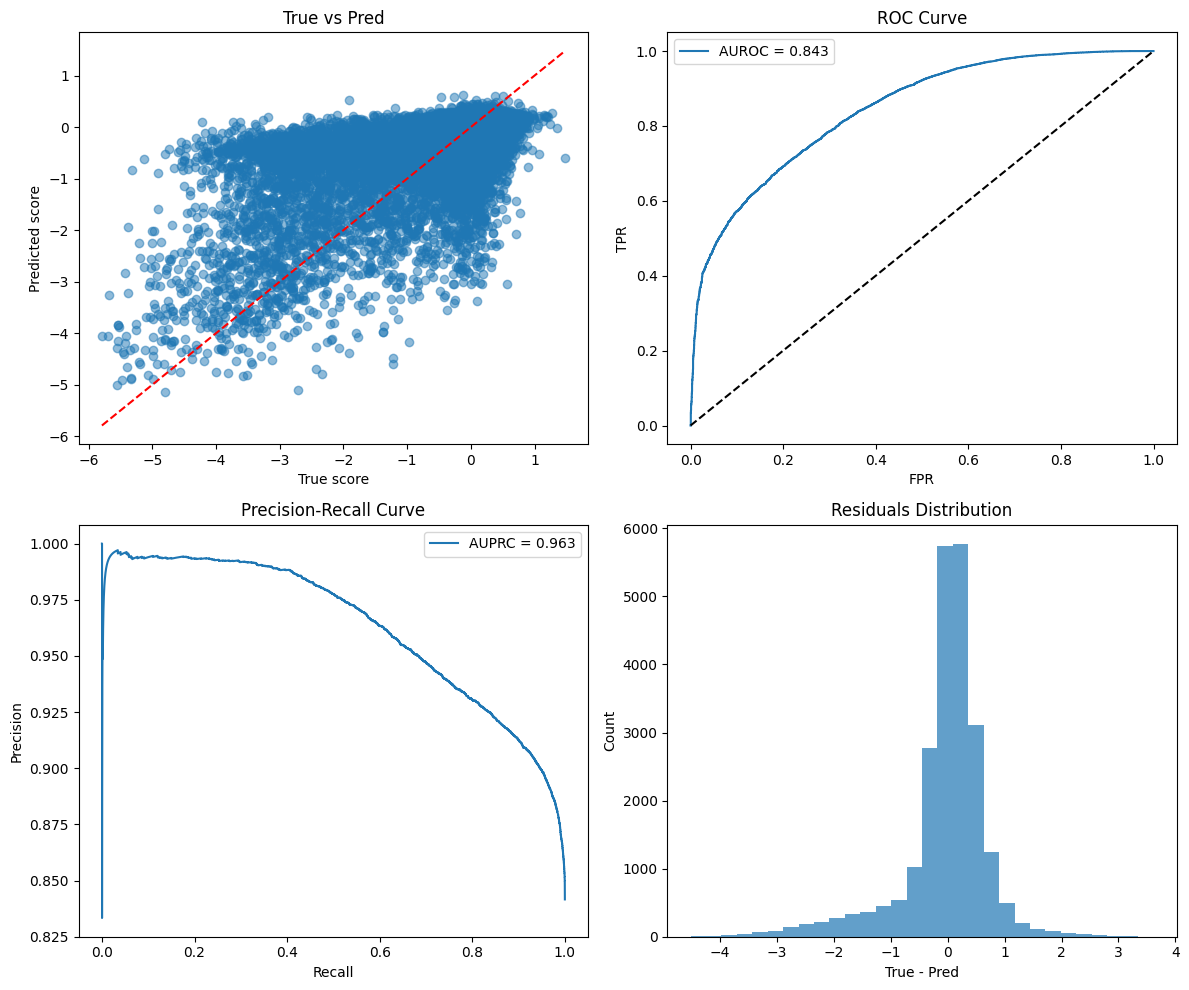

RuntimeError: to_padded_tensor: at least one constituent tensor should have non-zero numel

In [ ]:
model = CrossTransformer()

evaluate_and_plot('model.pt', model, TEST)

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import LayerIntegratedGradients

def plot_avg_ig_heatmap(model, data_loader, device='cuda', n_samples=100, n_steps=50):
    """
    model: your trained model (must have model.token aliasing the embedding)
    data_loader: yields (seq1, seq2, y)
    device: 'cuda' or 'cpu'
    n_samples: how many examples to sample & aggregate
    n_steps: IG integration steps
    """
    model.to(device).eval()
    # 1) gather a random batch of at least n_samples
    all_seq2 = []
    for seq1, seq2, _ in data_loader:
        all_seq2.append(seq2) # target!!!
        if sum(t.size(0) for t in all_seq2) >= n_samples:
            break
    seq2 = torch.cat(all_seq2, dim=0)[:n_samples].to(device)
    # fix the target to some dummy (won't use it here)
    dummy_target = seq2  # or any same-shape tensor

    # 2) compute IG for guide only
    baseline = torch.full_like(seq2, 4)  # use N_ID=4 as neutral
    lig = LayerIntegratedGradients(lambda g: model(baseline, g), model.token)
    attr = lig.attribute(
        inputs=seq2,
        baselines=baseline,
        n_steps=n_steps,
        internal_batch_size=1,
        return_convergence_delta=False
    )
    # sum over embedding dim → (n_samples, L)
    ig = attr.sum(dim=2).cpu().detach().numpy()

    # 3) aggregate per-base
    seq2_np = seq2.cpu().numpy()          # (n_samples, L)
    L       = seq2_np.shape[1]
    bases   = ['A','C','G','T']
    avg     = np.zeros((4, L), dtype=float)
    counts  = np.zeros((4, L), dtype=int)
    for k, base in enumerate([0,1,2,3]):
        mask = (seq2_np == 3-base)         # (n_samples, L)
        counts[k] = mask.sum(axis=0)
        # avoid division by zero
        avg[k] = (ig * mask).sum(axis=0) / np.maximum(counts[k], 1)

    # 4) plot heatmap
    fig, ax = plt.subplots(figsize=(12, 3))
    im = ax.imshow(avg[:, ::-1], aspect='auto', cmap='bwr', vmin=-np.max(np.abs(avg)), vmax=np.max(np.abs(avg)))
    ax.set_yticks(range(4))
    ax.set_yticklabels(bases, rotation=90)
    ax.set_xticks(range(L))
    ax.set_xticklabels(np.arange(1, L+1))
    ax.set_xlabel("Position in Sequence")
    ax.set_title(f"Average IG Attribution over {n_samples} Sequences")
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Avg Integrated Gradients")
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/captum/attr/_utils/batching.py:51: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 100 equal to the number of examples.
  warnings.warn(


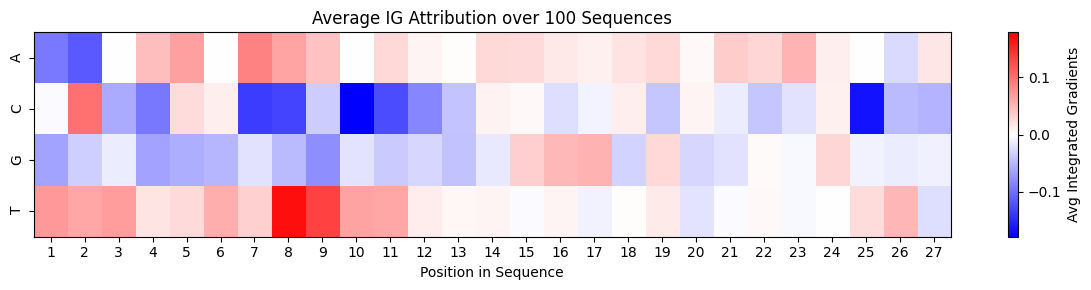

In [ ]:
model = CrossTransformer()
model.load_state_dict(torch.load('model.pt', map_location=device))
plot_avg_ig_heatmap(model, TEST, device='cuda', n_samples=100, n_steps=50)